In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv1D,MaxPooling1D,Concatenate,Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

In [8]:
!unzip -nq UCI-HAR.zip

In [9]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [10]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x

  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
  Ytrain = Ytrain.flatten()

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x

  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
  Ytest = Ytest.flatten()

  return Xtrain, Ytrain, Xtest, Ytest

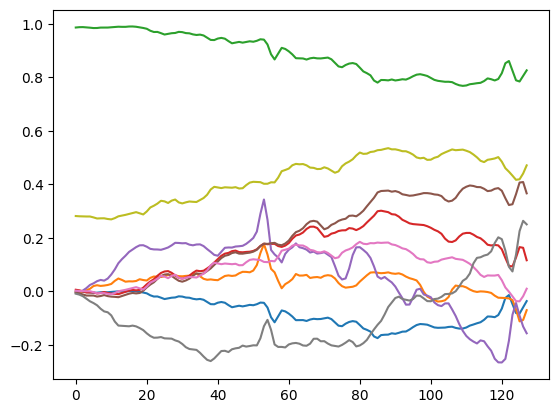

In [11]:
Xtrain, Ytrain, Xtest, Ytest = load_data()
plt.plot(Xtrain[7000, :, :]);

In [14]:
# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

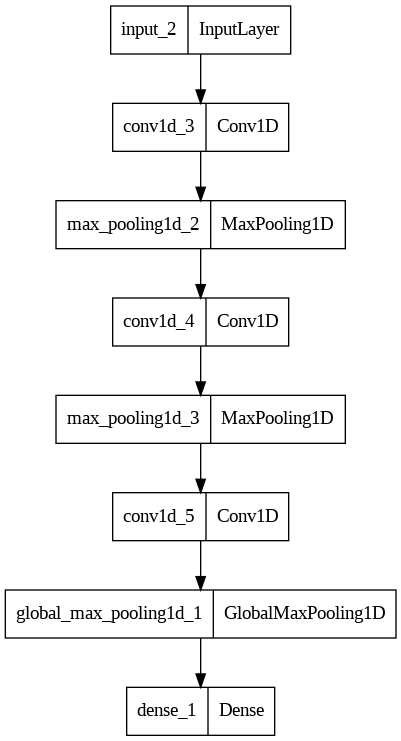

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True)

In [17]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [18]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/15
230/230 [==============================] - 3s 11ms/step - loss: 0.3864 - accuracy: 0.8689 - val_loss: 0.2280 - val_accuracy: 0.9094
Epoch 2/15
 30/230 [==>...........................] - ETA: 1s - loss: 0.1365 - accuracy: 0.9500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 2s 7ms/step - loss: 0.1305 - accuracy: 0.9501 - val_loss: 0.2312 - val_accuracy: 0.9186
Epoch 3/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1147 - accuracy: 0.9513 - val_loss: 0.1850 - val_accuracy: 0.9175
Epoch 4/15
230/230 [==============================] - 2s 7ms/step - loss: 0.1026 - accuracy: 0.9569 - val_loss: 0.1794 - val_accuracy: 0.9342
Epoch 5/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0969 - accuracy: 0.9587 - val_loss: 0.2177 - val_accuracy: 0.9199
Epoch 6/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0878 - accuracy: 0.9622 - val_loss: 0.1839 - val_accuracy: 0.9179
Epoch 7/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0817 - accuracy: 0.9644 - val_loss: 0.2229 - val_accuracy: 0.9155
Epoch 8/15
230/230 [==============================] - 2s 9ms/step - loss: 0.0906 - accuracy: 0.9623 - val_loss: 0.2263 - val_accuracy: 0.9135
Epoch 9/15
230/23

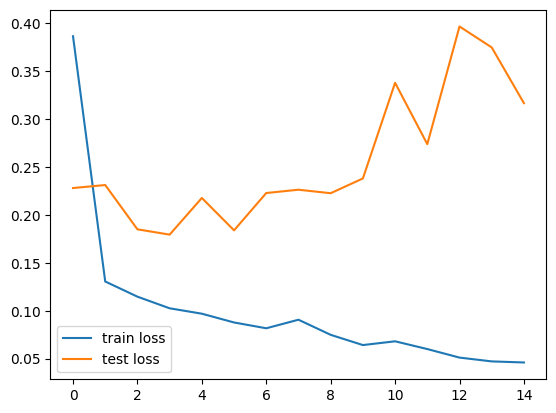

In [19]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

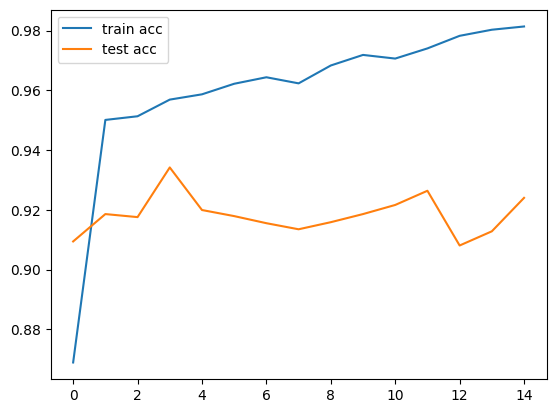

In [20]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [21]:
best_model = tf.keras.models.load_model('best_model.h5')
Ptest = best_model.predict(Xtest)
np.mean(np.argmax(Ptest, axis=1) == Ytest)

93/93 [==============================] - 0s 2ms/step


0.9341703427214116

In [22]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)

  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)

  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [23]:
feat_train, feat_test = load_features()
D_feat = feat_train.shape[1]

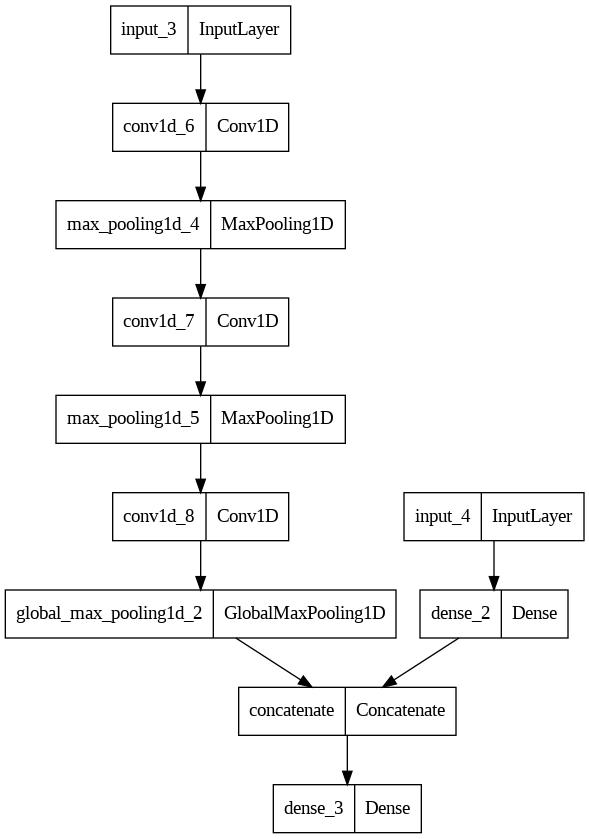

In [24]:
# Combined Model

# CNN
i = Input(shape=(T, D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(64, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)
tf.keras.utils.plot_model(model)

In [25]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5', monitor='val_accuracy', save_best_only=True)

In [26]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [27]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point3],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 3s 9ms/step - loss: 0.2346 - accuracy: 0.9139 - val_loss: 0.1601 - val_accuracy: 0.9427
Epoch 2/15
 26/230 [==>...........................] - ETA: 1s - loss: 0.0737 - accuracy: 0.9700

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


230/230 [==============================] - 2s 7ms/step - loss: 0.0691 - accuracy: 0.9737 - val_loss: 0.1680 - val_accuracy: 0.9450
Epoch 3/15
230/230 [==============================] - 2s 10ms/step - loss: 0.0500 - accuracy: 0.9796 - val_loss: 0.1415 - val_accuracy: 0.9518
Epoch 4/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0431 - accuracy: 0.9837 - val_loss: 0.1578 - val_accuracy: 0.9488
Epoch 5/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0381 - accuracy: 0.9849 - val_loss: 0.1357 - val_accuracy: 0.9555
Epoch 6/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0360 - accuracy: 0.9869 - val_loss: 0.1373 - val_accuracy: 0.9552
Epoch 7/15
230/230 [==============================] - 2s 8ms/step - loss: 0.0299 - accuracy: 0.9886 - val_loss: 0.2093 - val_accuracy: 0.9382
Epoch 8/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0282 - accuracy: 0.9902 - val_loss: 0.2004 - val_accuracy: 0.9393
Epoch 9/15
230/2

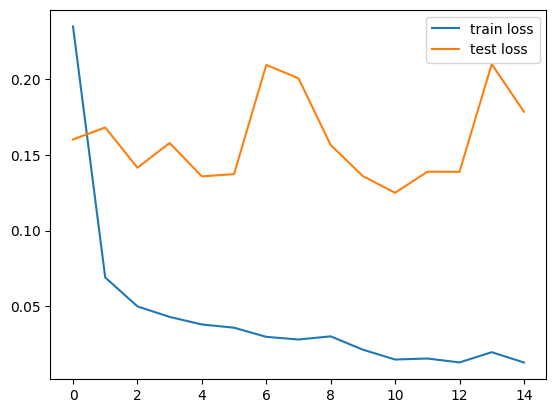

In [28]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

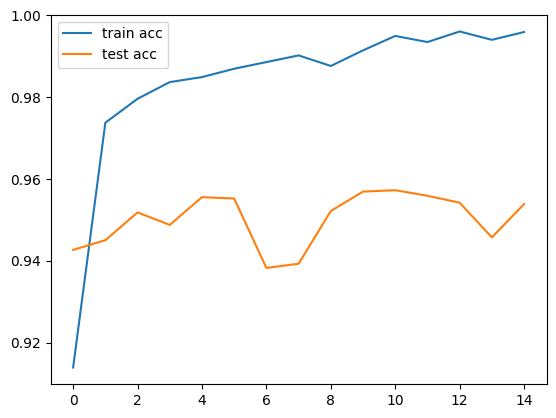

In [29]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [30]:
best_model = tf.keras.models.load_model('best_model_combined.h5')
Ptest = best_model.predict([Xtest, feat_test])
np.mean(np.argmax(Ptest, axis=1) == Ytest)

93/93 [==============================] - 0s 2ms/step


0.9572446555819477